<table style="width:100%">
  <tr>
    <td><img alt="Departamento de Matemáticas, Estadística e Invest. Operativa" src="https://drive.google.com/uc?export=view&id=1B6ZDkYRWMjlPk0CMUnr3Yf-T8xDWZnkI" width="500"></td> 
  </tr> 
</table>


# Predictive modelling of 2019-nCov outbreak data
#### Authors: Roberto Dorta Guerra, Arturo J. Fernández Rodríguez, Carlos J. Pérez González 

*   [1. Introduction](#intro)
*   [2. Loading required libraries](#libraries)
*   [3. Data source](#source)
*   [3.1 Read and arrange data](#read)
*   [4. Fitting model to data](#fit)
*   [4.1 Making predictions](#predict)
*   [4.2 Table and plot of observed and predicted data](#plot)
*   [5. References](#references)

<a id='intro'></a>
## 1. Introduction

We have made the current notebook to present the predictive models that we are using in this outbreak to predict the number of infected people and hospitalized patients. 

Feel free to use it for your own contributions. Please, cite this work
????????????????????????????



<a id='libraries'></a>
## 2. Loading required libraries

We load the required libraries to perform the diferent data analysis and prediction modelling

In [0]:
require("dplyr")
require("tidyr")
require("reshape2")
require("ggplot2")
if (!require("drc")) install.packages("drc")
require("drc")
if (!require("gridExtra")) install.packages("gridExtra")
require("gridExtra")

<a id='source'></a>
## 3. Data source

Data processed in this notebook are obtained from [Datadista COVID19 Github repository](https://github.com/datadista/datasets/tree/master/COVID%2019). Data includes the total of confirmed cases, the hospitalized pacients and the hospitalized with severe Covid-19 admitted to the intensive care unit (ICU) by autonomous community since outbreak start in Spain.



<a id='read'></a>
### 3.1 Read and arrange data

The following function *read_from_github()* help us to read data from Github repo (we have selected the tables with the number of confirmed cases, recovered patients, death toll as well as the hospitalized patients and hospitalized in ICUs) and arrange them in an appropriate way to use them for fitting and predicting. We have created another function *filter_ccaa_data()* to filter data by CCAA and replace NA values in the different variables.  

In [0]:
read_from_github<-function(table_name) {
  #data<-data %>% dplyr::select(-the_geom) 
  data<-readr::read_csv(sprintf("https://raw.githubusercontent.com/datadista/datasets/master/COVID%%2019/ccaa_covid19_%s.csv",table_name))
  data<-data %>% unnest(cols=colnames(data)) %>% data.frame(stringsAsFactors = FALSE)
  data<-data %>% melt(id = c("cod_ine","CCAA")) %>% arrange(CCAA) %>% 
    dplyr::rename(date_ref=variable) %>% 
    #mutate(date=as.Date(gsub("_","/",substring(as.character(date_ref),3)),format="%d/%m/%y")) %>%
    mutate(date=as.Date(gsub("\\.","/",substring(as.character(date_ref),2)),format="%Y/%m/%d")) %>%
    mutate(date_ref=as.character(date_ref)) %>%
    dplyr::select(cod_ine,CCAA,date_ref,date,value) %>%
    dplyr::rename(ccaa=CCAA)
  return(data)
}

filter_ccaa_data<-function(data, name_ccaa) {
  data_can<-data %>% filter(ccaa==name_ccaa & var %in% c("casos","altas","fallecidos","uci","hospitalizados")) 
  #covid_can<- covid_can %>% filter(date<="2020-03-31")
  
  data_can<-reshape2::dcast(data_can, cod_ine+ccaa+date_ref+date~var) %>% 
    arrange(date) %>% mutate(casos=ifelse(is.na(casos),0,casos),
                             altas=ifelse(is.na(altas),0,altas))
  
  data_can<-data_can %>% mutate(fallecidos=ifelse(date<max(date[fallecidos==0],na.rm = TRUE),0,fallecidos),
                                  uci=ifelse(date<max(date[uci==0],na.rm = TRUE),0,uci))
  data_can
}

Firstly, we create a full *data.frame* with the different variables of interest.

In [0]:
table_name <- "casos"
covid_full_data <- read_from_github(table_name) 
template_data <-covid_full_data %>% dplyr::select(cod_ine,ccaa,date_ref,date) 
covid_full_data <- covid_full_data %>% cbind(var=table_name)

table_name <- "fallecidos"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_ref","date")) %>% 
                           cbind(var=table_name))

table_name <- "altas"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_ref","date")) %>% 
                           cbind(var=table_name))

table_name <- "uci"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_ref","date")) %>% 
                           cbind(var=table_name))

table_name <- "hospitalizados"
covid_full_data <- rbind(covid_full_data,
                         template_data %>% left_join(read_from_github(table_name),
                                                     by=c("cod_ine","ccaa","date_ref","date")) %>% 
                           cbind(var=table_name))



Then, we can view the different variables of our dataset:
* cod_ine: The INE code of the community (and city) autonomous 
* ccaa: The name of the community and city autonomous 
* date_ref: The original source files show the different variables by dates shown in columns.
* date: Date variable of reference
* value: Value of the corresponding variable
* var: Variable of analysis ("casos": confirmed cases,  "fallecidos": deaths, "altas": recovered cases, "hospitalizados": hospitalized patients, "uci": hospitalized patients in ICU) 

In [0]:
head(covid_full_data)

,cod_ine,ccaa,date_ref,date,value,var
,<chr>,<chr>,<chr>,<date>,<dbl>,<fct>
1,01,Andalucía,X2020.02.27,2020-02-27,1,casos
2,01,Andalucía,X2020.02.28,2020-02-28,6,casos
3,01,Andalucía,X2020.02.29,2020-02-29,8,casos
4,01,Andalucía,X2020.03.01,2020-03-01,12,casos
5,01,Andalucía,X2020.03.02,2020-03-02,12,casos
6,01,Andalucía,X2020.03.03,2020-03-03,13,casos


<a id='fit'></a>
## 4. Fitting model to data

We use the log-logistic model to describe the Covid-19 epidemic in the Canary Islands. This model has been considered to describe the growth of a population. The epidemic can be seen as the growth of the population of a pathogen and the use of a logistic model could be reasonable (see [Malato, 2020](#Malato)).

This model starts with an exponential growth but gradually decreases its
specific growth rate. Therefore, the model is useful to describe an infection growth that is expected to stop in the future.

The four-parameter log-logistic function implemented in *drc* library is given by the expression (see  [Seber and Wild, 1989](#Seber))
$$Y(t) = c + \frac{d-c}{1+\exp\{b(\log(t)-e)\}}$$

In this formula, time variable is represented as $t$ there are four  parameters: 
* b represents the velocity of infection spreading.
* e is the t-value of the sigmoid's midpoint 
* c and d represent the minimum and maximum values of the curve



We filter the full dataset to get the Covid-19 data of Canary Islands and we fit the model to the number of confirmed coronavirus cases since March, 23 until now

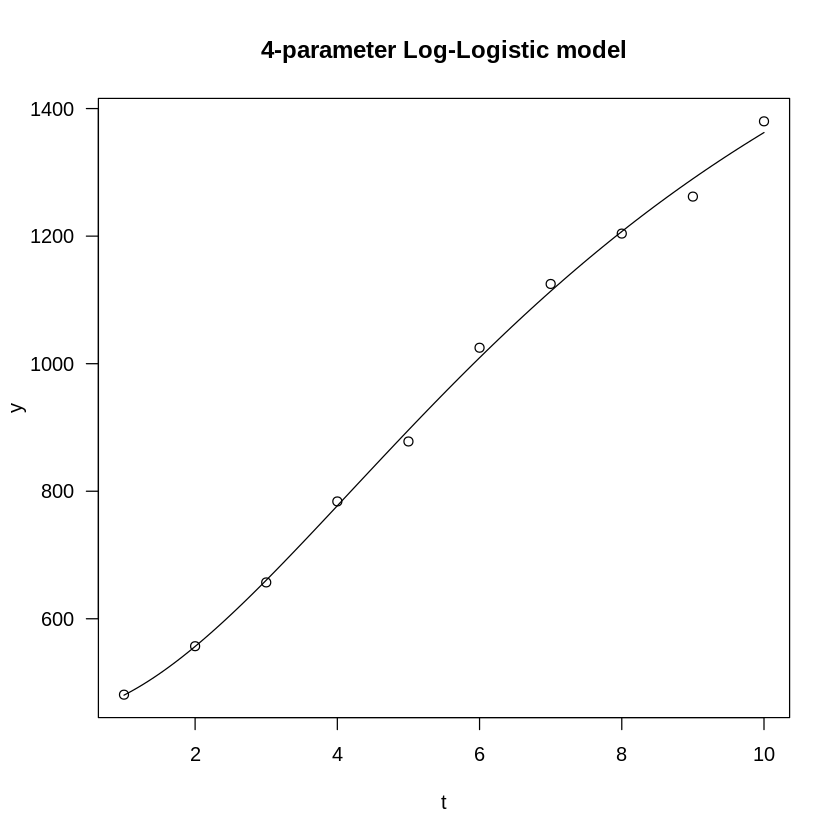

In [0]:
covid_can<-filter_ccaa_data(covid_full_data,"Canarias")
covid_can$var<-covid_can$casos
date_ref<-"2020-03-23"
covid_can<-covid_can[covid_can$date>=date_ref,]

data.CANCOV<-data.frame(date=covid_can$date,
                        t=seq_along(covid_can$var),
                        y=covid_can$var)

model.CANCOV <- drm(y ~ t, data  = data.CANCOV, fct=LL.4())
plot(model.CANCOV, log="", main = "4-parameter Log-Logistic model")
data.CANCOV$pred<-predict(model.CANCOV)


<a id='predict'></a>
### 4.1 Making predictions 

Now, we can obtain the predictions for the next days using the following function *pred.CANCOV()*

In [0]:
pred.CANCOV <- function(model,data,idx) {
  cbind(
    data.frame(date=tail(data$date,1)+idx,
               t=tail(data$t,1)+idx,
               y=NA),
    predict(model, level=0.95,
            newdata=data.frame(t = tail(data$t,1)+idx), 
            interval = "prediction")
  )
}

A data.frame with the observed data is merged with the predictions of the next three days

In [0]:
predict.CANCOV<-pred.CANCOV(model.CANCOV,data.CANCOV,1:3)
colnames(predict.CANCOV)[4:6]<-c("pred","lwr","upr")
data.CANCOV[,c("lwr", "upr")]<-NA
data.CANCOV<-rbind(data.CANCOV,predict.CANCOV)
head(data.CANCOV,13)


Warning message in (tquan * sqrt(varVal + sumObjRV)) * c(-1, 1):
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in (tquan * sqrt(varVal + sumObjRV)) * c(-1, 1):
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in (tquan * sqrt(varVal + sumObjRV)) * c(-1, 1):
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”


,date,t,y,pred,lwr,upr
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-03-23,1,481,480.2144,NA,NA
2,2020-03-24,2,557,556.6092,NA,NA
3,2020-03-25,3,657,660.4757,NA,NA
4,2020-03-26,4,784,777.2484,NA,NA
5,2020-03-27,5,878,895.9131,NA,NA
6,2020-03-28,6,1025,1009.3337,NA,NA
7,2020-03-29,7,1125,1113.6286,NA,NA
8,2020-03-30,8,1204,1207.2161,NA,NA
9,2020-03-31,9,1262,1289.9399,NA,NA


<a id='plot'></a>
### 4.2 Table and plot of observed and predicted data

The following functions() help us to represent in a chart the observed number of Covid-19 cases and the prediction for the next days

In [0]:
plot_covid<-function(data,title,subtitle,legend,breaks=100) {
  p<-ggplot(subset(data,date<=min(data$date[is.na(data$y)])), 
            mapping = aes(x = date, y = pred,color="red1") ) +   
    geom_line(size =1.25)+ 
    geom_line(subset(data,is.na(y)),mapping=aes(x=date,y=pred),inherit.aes = FALSE,color="blue",linetype="dashed")+ 
    geom_point(subset(data,is.na(y)),mapping=aes(x=date,y=pred),inherit.aes = FALSE,color="blue",size=2.1)+
    geom_ribbon(subset(data,is.na(y)),mapping=aes(x=date,ymin=lwr,ymax=upr),inherit.aes = FALSE,
                color="blue",alpha=0.3)+
    geom_point(subset(data,date>="2020-03-16"),
               mapping=aes(x=date,y=y),inherit.aes = FALSE,size=2.1)+
    scale_color_manual( values = "red1",labels = legend)+ 
    theme(
      plot.title = element_text(size = 24, face = "bold",hjust = 0.5),
      plot.subtitle = element_text(size = 18,hjust = 0.5),
      plot.caption = element_text(size = 12, face = "italic"),
      legend.position="top",
      legend.title = element_blank(),
      legend.box = "horizontal" ,
      legend.text=element_text(size=14),
      panel.grid.minor = element_blank(), 
      panel.grid.major = element_line(color = "gray50", size = 1.0),
      panel.grid.major.x = element_blank(),
      panel.background = element_blank(),
      line = element_blank(),
      axis.ticks.length = unit(.15, "cm"),
      axis.ticks.y = element_blank(),
      axis.title.x = element_text(color="black", 
                                  size=18),
      axis.title.y = element_text(color="black",
                                  size=18),
      axis.text.x = element_text(angle = -90, hjust = 1, size=14),
      axis.text.y = element_text(size=14) )+
    
    scale_y_continuous(expand = c(0, 0),
                       limits=c(0.0,plyr::round_any(max(data$upr,na.rm=TRUE), breaks, f = ceiling)),
                       breaks=seq(0.0,plyr::round_any(max(data$upr,na.rm=TRUE), breaks, f = ceiling),breaks), labels = scales::comma,
                       name = "Número de individuos")+
    
    scale_x_date(expand=c(0.01,0),
                 date_breaks="1 days",
                 date_labels = "%d/%m/%Y",name = "Día") +
    
    labs(title = title, 
         subtitle=subtitle,
         caption = "Fuente: Ministerio de Sanidad (elab. por Carlos Pérez-Glez)."
    )
  p
  
}

annotate_estim_plot_covid<-function(plotchart,data,date,ypos) {
  plotchart+annotation_custom(
    grob = data %>% filter(is.na(y)) %>% dplyr::select(date,lwr,pred,upr) %>% 
      dplyr::mutate(lwr=round(lwr, digits = 1),
                    pred=round(pred, digits = 1),
                    upr=round(upr, digits = 1)) %>%
      dplyr::rename("Fecha"=date,"Min."=lwr,"Estimación"=pred,"Max."=upr) %>% tableGrob(rows = NULL, theme=ttheme_default(core = list(fg_params=list(cex = 1.5)))),
    xmin = as.Date(date),
    xmax = as.Date(date)+6,
    ymin = ypos
    ) 
}

annotate_date_plot_covid<-function(plotchart,label,date,ypos) {
  plotchart+geom_vline(xintercept = as.Date(date), linetype="dashed", 
                       color = "blue", size=1.2)+
    annotate(geom="text", x=as.Date(date)+0.1, y=ypos, label=label,color="black",hjust = 0, size=6)
  
}

We represent the data with the corresponding prediction bands, and we remark a particular day event of our interest

Warning message:
“Removed 3 rows containing missing values (geom_point).”


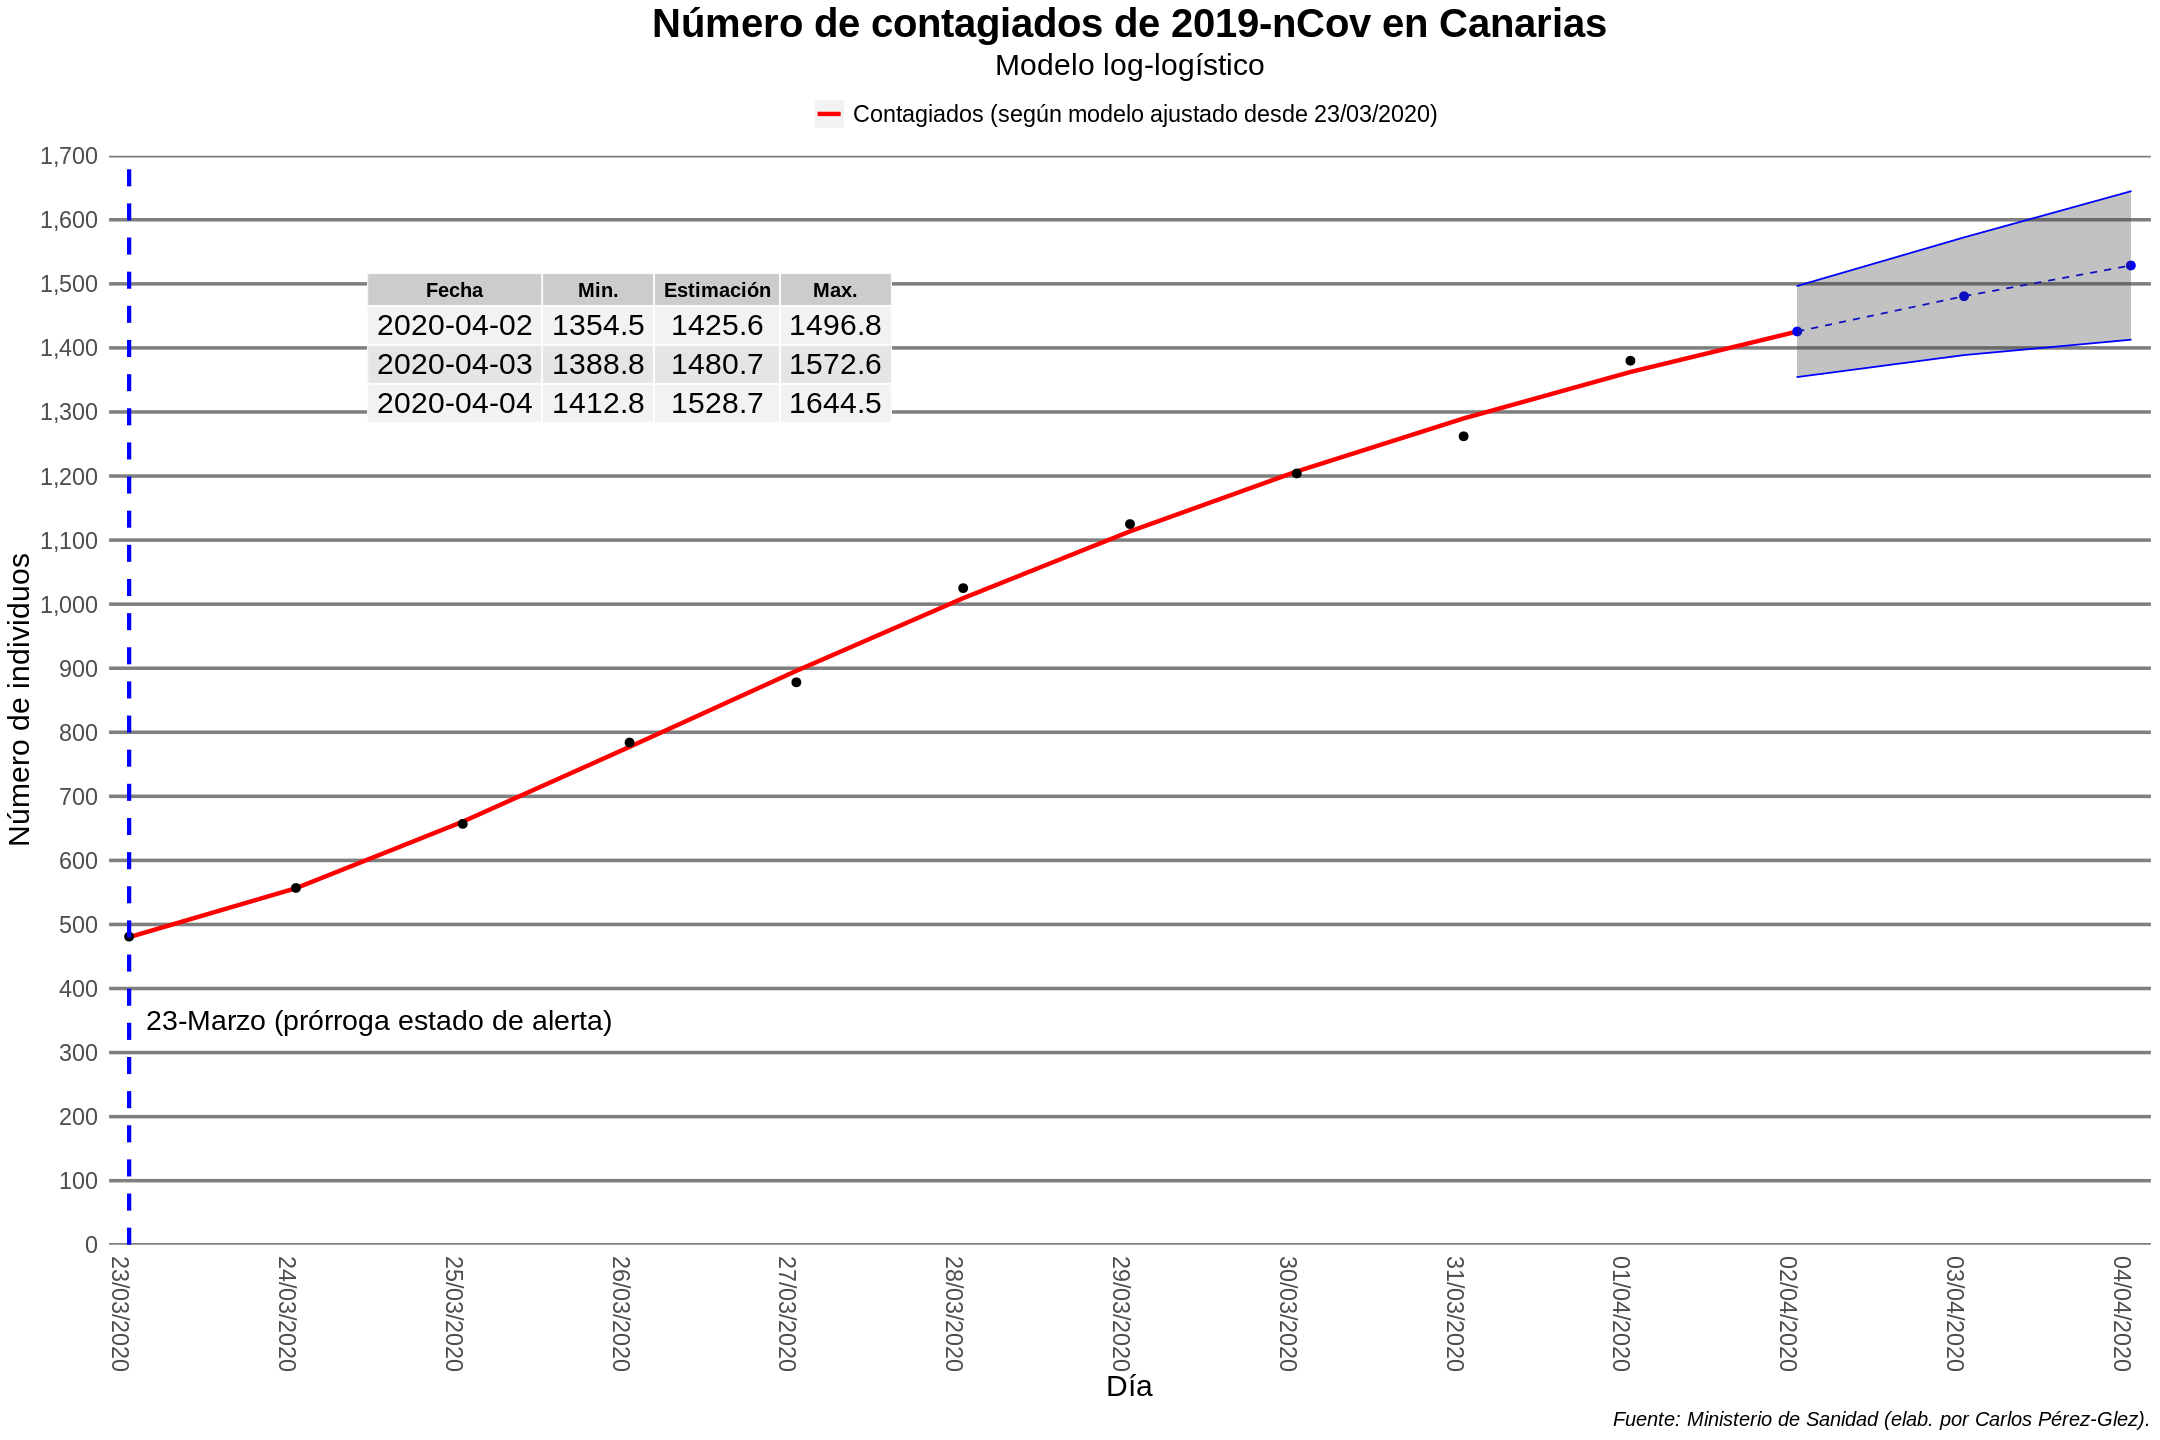

In [0]:
options(repr.plot.width=18, repr.plot.height=12)
plot.CANCOV<-plot_covid(data.CANCOV,
                        "Número de contagiados de 2019-nCov en Canarias",
                        "Modelo log-logístico",
                        "Contagiados (según modelo ajustado desde 23/03/2020)")

plot.CANCOV %>% annotate_date_plot_covid(label="23-Marzo (prórroga estado de alerta)",
                                         date="2020-03-23",ypos=350) %>% 
                annotate_estim_plot_covid(data.CANCOV,
                                          date="2020-03-23",ypos=1100)


We can apply the same methodology to predicting the number of hospitalized patients as well as the recovered pepole.

<a id='references'></a>
## 5. References

<a id='Seber'></a> [1] Seber, G. A. F. and Wild, C. J (1989) Nonlinear Regression, New York: Wiley & Sons.

<a id='Malato'></a> [2] Malato. G. (2020, March 8). [Covid-19 infection in Italy. Mathematical models and predictions. A comparison of logistic and exponential models applied to Covid-19 virus infection in Italy](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d). Medium: Towards Data Science. 
